In [6]:
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import joblib
import time
import pickle
import sklearn.metrics as metrics
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import make_scorer

from multioutput_functions import *

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report

In [8]:
def f1score_jd(true_Y,pred_Y):
    f1_score=[]
    weights=[]
    totlength = len(true_Y)

    for value in [0,1]:
        tp = 0
        fn = 0
        fp = 0
        tn = 0
        match_value = np.where(np.array(true_Y) == pred_Y)[0]
        postn_value = np.where(true_Y ==  value)[0]
        weights.append(len(postn_value)/totlength)
        for i in postn_value:
            if i in match_value:
                tp +=1
            elif i not in match_value:
                fn +=1
        for i in match_value:
            if i not in postn_value:
                tn +=1
        fp = len(true_Y)-tn-fn-tp

        if tp==0:
            precision = 0
            recall = 0
            f1_score = 0
        else:
            precision = tp/(fp+tp)
            recall    = tp/(fn+tp)
            f1_score.append(2*precision*recall/(precision + recall))
    
    f1_weighted = np.array(f1_score)*np.array(weights)

    # return np.nanmean(f1_score)
    return np.nansum(f1_weighted)

In [9]:
def RF_optimize(DF_,wave,telluric=False,optimization=False,jobs=-1,Group=''):

    Bardalez = ['G1','Bardalez']
    Burgasser = ['G2','Burgasser']
    alltypes = ['G3','all','']
    earlytypes = ['G4','late']
    if Group in Bardalez:
        typerange=[[16,27],[31,38]]
    elif Group in Burgasser:
        typerange=[[25,32],[32,38]]
    elif Group in alltypes:
        typerange=[[16,39],[16,39]]
    elif Group in earlytypes:
        typerange=[[16,30],[16,32]]
    elif (type(Group)==list):
        if len(Group)==2:
            if (len(Group[0])==2)&(len(Group[1])==2):
                typerange=Group
    else:
        return print('Error. Select a valid group')
    
    
    sins=DF_[DF_.num_class==0]
    bins=DF_[DF_.num_class==1]
    
    if 'primary_type' in DF_.columns:
        bins = bins[bins.primary_type>=typerange[0][0]]
        bins = bins[bins.primary_type<=typerange[0][1]]
        bins = bins[bins.secondary_type>=typerange[1][0]]
        bins = bins[bins.secondary_type<=typerange[1][1]]
    else:
        return print('Include a column with the primary and secondary types for the binaries')

    if 'system_interpolated_flux' in DF_.columns:
        fluxcolname = 'system_interpolated_flux'
    elif 'FLUX' in DF_.columns:
        fluxcolname = 'FLUX'
    else: return print('Missing flux column')
    if 'system_interpolated_noise' in DF_.columns:
        noisecolname = 'system_interpolated_noise'
    elif 'UNCERTAINTY' in DF_.columns:
        noisecolname = 'UNCERTAINTY'
    else: return print('Missing noise column')

    bin_types=[]
    for flux_i,noise_i in zip(bins[fluxcolname],bins[noisecolname]):
        bin_types.append(typeToNum(fast_classify(wave,flux_i,noise_i)))

    sin_types=[]
    for flux_i,noise_i in zip(sins[fluxcolname],sins[noisecolname]):
        sin_types.append(typeToNum(fast_classify(wave,flux_i,noise_i)))
    sin_types = np.array(sin_types)
    sins = sins[(sin_types>=min(bin_types)) & (sin_types<=max(bin_types))]
    
    DF_ = pd.concat([sins,bins.drop(['primary_type','secondary_type'],axis=1)],axis=0)


    RSEED = 42  

    feats = ['flux_' + str(k) for k in range(409)]

    
    X0 = np.array(DF_[feats]) #data
    y0 = np.array(DF_['num_class']) #labels 

    X_train, X_test, y_train, y_test = train_test_split(X0,y0,train_size=0.7, random_state=RSEED, shuffle=True)
    if telluric:
        tm = np.logical_or(np.logical_and(wave > 1.35,wave < 1.42), np.logical_and(wave > 1.8,wave < 1.95))
        X_train = np.array([X_train[i][~tm] for i in range(len(X_train))])
        X_test = np.array([X_test[i][~tm] for i in range(len(X_test))])
    data_test = {'X_test':X_test,
                'y_test':y_test}

    param_grid = dict(n_estimators=[int(i) for i in np.linspace(1,151,76)],max_depth=[15,25,None])
    custom_scorer = make_scorer(f1score_jd, greater_is_better=True)
    RF = RandomForestClassifier()
    grid_search = RandomizedSearchCV(RF, param_grid, n_jobs=-1, n_iter=12, scoring=custom_scorer)

    grid_search.fit(X_train, y_train)
    return grid_search, data_test

In [13]:
with open('data/SinDF_mid.pickle', 'rb') as f:
        SinDF_mid=pickle.load(f)
with open('data/BinDF_mid.pickle', 'rb') as f:
        BinDF_mid = pickle.load(f)
# BinDF_mid.drop(['primary_type','secondary_type'],axis=1,inplace=True)

num_class=[]
for i in range(len(BinDF_mid)):
    num_class.append(1)
BinDF_mid["num_class"]=num_class

num_class=[]
for i in range(len(SinDF_mid)):
    num_class.append(0)
SinDF_mid["num_class"]=num_class

DF_mid = pd.concat([SinDF_mid,BinDF_mid],axis=0)

In [14]:
wave = DF_mid['WAVE'].iloc[0]

In [15]:
start = time.time()
grid_mid_G1, data_mid_G1 = RF_optimize(DF_mid, wave, Group='G1')
RF_mid_G1 = grid_mid_G1.best_estimator_
X_mid_G1 = data_mid_G1['X_test']
y_mid_G1 = data_mid_G1['y_test']
z_mid_G1 = RF_mid_G1.predict(X_mid_G1)
end = time.time()
print(end-start)

399.0000829696655


In [16]:
grid_mid_G1.cv_results_

{'mean_fit_time': array([ 63.02563968, 107.89685106,  43.02994022,  10.13327355,
         94.14133983, 153.82444835,  59.07583942,  82.829495  ,
         78.1244874 ,  68.53383098,   1.30283585,  24.53862114]),
 'std_fit_time': array([0.61284919, 0.6747701 , 0.35713273, 0.26977117, 1.55253669,
        1.24815198, 1.17912646, 1.77369135, 0.86805417, 7.30401317,
        0.09791524, 0.20518837]),
 'mean_score_time': array([0.5260951 , 0.78267183, 0.4614027 , 0.34055047, 0.6466886 ,
        0.88268323, 0.52606769, 0.61383181, 0.48527436, 0.30529304,
        0.30441751, 0.31938558]),
 'std_score_time': array([0.00747713, 0.06531305, 0.01807419, 0.008218  , 0.03485402,
        0.04249964, 0.03338471, 0.02070324, 0.10695537, 0.03325713,
        0.009673  , 0.02950174]),
 'param_n_estimators': masked_array(data=[59, 119, 47, 11, 83, 139, 53, 75, 89, 95, 1, 25],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        f

In [17]:
f1score_jd(y_mid_G1,z_mid_G1)

0.9630874306498248

The raw features produce a model with precision ~0.9895
{'0': {'precision': 0.9551549075761521, 'recall': 0.9963337633240545, 'f1-score': 0.975309872727877, 'support': 14729}, '1': {'precision': 0.9894900739587388, 'recall': 0.8806513078122293, 'f1-score': 0.9319035835395474, 'support': 5773}, 'accuracy': 0.9637596332065165, 'macro avg': {'precision': 0.9723224907674455, 'recall': 0.9384925355681419, 'f1-score': 0.9536067281337122, 'support': 20502}, 'weighted avg': {'precision': 0.9648230821701759, 'recall': 0.9637596332065165, 'f1-score': 0.9630874306498247, 'support': 20502}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

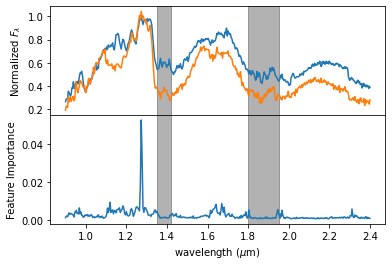

In [18]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_mid_G1, z_mid_G1)))
class_report_mid_G1 = classification_report(y_mid_G1,z_mid_G1, digits=4, output_dict=True)
print(class_report_mid_G1)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_mid))
Bin_i = random.randint(0,len(BinDF_mid))
ax[0].plot(list(wave),list(SinDF_mid.system_interpolated_flux.iloc[Sin_i]),label='single')
ax[0].plot(list(wave),list(BinDF_mid.system_interpolated_flux.iloc[Bin_i]),label='binary')
ax[0].set_ylabel('Normalized $F_\\lambda$')
ax[1].plot(list(wave), list(RF_mid_G1.feature_importances_)[:409])
ax[1].set_ylabel('Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

The raw features produce a model with precision ~0.9895
{'0': {'precision': 0.9551549075761521, 'recall': 0.9963337633240545, 'f1-score': 0.975309872727877, 'support': 14729}, '1': {'precision': 0.9894900739587388, 'recall': 0.8806513078122293, 'f1-score': 0.9319035835395474, 'support': 5773}, 'accuracy': 0.9637596332065165, 'macro avg': {'precision': 0.9723224907674455, 'recall': 0.9384925355681419, 'f1-score': 0.9536067281337122, 'support': 20502}, 'weighted avg': {'precision': 0.9648230821701759, 'recall': 0.9637596332065165, 'f1-score': 0.9630874306498247, 'support': 20502}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

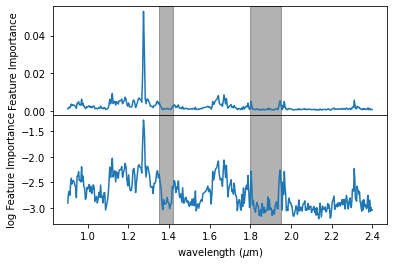

In [19]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_mid_G1, z_mid_G1)))
class_report_mid_G1 = classification_report(y_mid_G1,z_mid_G1, digits=4, output_dict=True)
print(class_report_mid_G1)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_mid))
Bin_i = random.randint(0,len(BinDF_mid))
ax[0].plot(list(wave), list(RF_mid_G1.feature_importances_)[:409])
ax[0].set_ylabel('Feature Importance')
ax[1].plot(list(wave), np.log10(list(RF_mid_G1.feature_importances_)[:409]))
ax[1].set_ylabel('log Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

In [20]:
start = time.time()
grid_mid_G2, data_mid_G2 = RF_optimize(DF_mid, wave, Group='G2')
RF_mid_G2 = grid_mid_G2.best_estimator_
X_mid_G2 = data_mid_G2['X_test']
y_mid_G2 = data_mid_G2['y_test']
z_mid_G2 = RF_mid_G2.predict(X_mid_G2)
end = time.time()
print(end-start)

232.56605744361877


In [21]:
grid_mid_G2.cv_results_

{'mean_fit_time': array([32.84738684, 43.04051309,  2.15722613, 58.74030957, 66.14450665,
        69.39628587, 78.48346648, 17.62176743,  5.21624074, 49.54203901,
         6.23581624, 43.47296638]),
 'std_fit_time': array([0.58343415, 0.54599245, 0.04494426, 1.5285354 , 0.69012864,
        0.89617002, 0.80569237, 0.29555896, 0.07513124, 0.50768728,
        0.08496981, 0.6096532 ]),
 'mean_score_time': array([0.29008784, 0.33791113, 0.20326519, 0.35138507, 0.39302144,
        0.40713525, 0.37175951, 0.24591126, 0.20027518, 0.23900242,
        0.19691987, 0.17952724]),
 'std_score_time': array([0.00725356, 0.01340476, 0.02446923, 0.01326387, 0.01086016,
        0.0220415 , 0.01501035, 0.01032064, 0.00631005, 0.02263826,
        0.00182818, 0.01496072]),
 'param_n_estimators': masked_array(data=[57, 81, 3, 101, 125, 123, 141, 31, 9, 97, 11, 93],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='

In [22]:
f1score_jd(y_mid_G2,z_mid_G2)

0.9917368871009503

The raw features produce a model with precision ~0.9994
{'0': {'precision': 0.9895380057402092, 'recall': 0.9998129092609915, 'f1-score': 0.994648922804895, 'support': 10690}, '1': {'precision': 0.9993748046264458, 'recall': 0.9658610271903323, 'f1-score': 0.9823321554770319, 'support': 3310}, 'accuracy': 0.9917857142857143, 'macro avg': {'precision': 0.9944564051833276, 'recall': 0.9828369682256619, 'f1-score': 0.9884905391409635, 'support': 14000}, 'weighted avg': {'precision': 0.9918637060483122, 'recall': 0.9917857142857143, 'f1-score': 0.9917368871009503, 'support': 14000}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

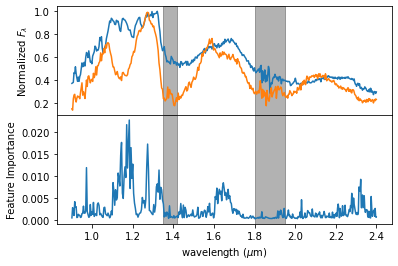

In [23]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_mid_G2, z_mid_G2)))
class_report_mid_G2 = classification_report(y_mid_G2,z_mid_G2, digits=4, output_dict=True)
print(class_report_mid_G2)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_mid))
Bin_i = random.randint(0,len(BinDF_mid))
ax[0].plot(list(wave),list(SinDF_mid.system_interpolated_flux.iloc[Sin_i]),label='single')
ax[0].plot(list(wave),list(BinDF_mid.system_interpolated_flux.iloc[Bin_i]),label='binary')
ax[0].set_ylabel('Normalized $F_\\lambda$')
ax[1].plot(list(wave), list(RF_mid_G2.feature_importances_)[:409])
ax[1].set_ylabel('Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

The raw features produce a model with precision ~0.9994
{'0': {'precision': 0.9895380057402092, 'recall': 0.9998129092609915, 'f1-score': 0.994648922804895, 'support': 10690}, '1': {'precision': 0.9993748046264458, 'recall': 0.9658610271903323, 'f1-score': 0.9823321554770319, 'support': 3310}, 'accuracy': 0.9917857142857143, 'macro avg': {'precision': 0.9944564051833276, 'recall': 0.9828369682256619, 'f1-score': 0.9884905391409635, 'support': 14000}, 'weighted avg': {'precision': 0.9918637060483122, 'recall': 0.9917857142857143, 'f1-score': 0.9917368871009503, 'support': 14000}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

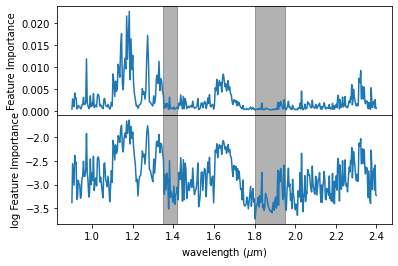

In [24]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_mid_G2, z_mid_G2)))
class_report_mid_G2 = classification_report(y_mid_G2,z_mid_G2, digits=4, output_dict=True)
print(class_report_mid_G2)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_mid))
Bin_i = random.randint(0,len(BinDF_mid))
ax[0].plot(list(wave), list(RF_mid_G2.feature_importances_)[:409])
ax[0].set_ylabel('Feature Importance')
ax[1].plot(list(wave), np.log10(list(RF_mid_G2.feature_importances_)[:409]))
ax[1].set_ylabel('log Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

In [25]:
start = time.time()
grid_mid_G3, data_mid_G3 = RF_optimize(DF_mid, wave, Group='G3')
RF_mid_G3 = grid_mid_G3.best_estimator_
X_mid_G3 = data_mid_G3['X_test']
y_mid_G3 = data_mid_G3['y_test']
z_mid_G3 = RF_mid_G3.predict(X_mid_G3)
end = time.time()
print(end-start)

844.1350364685059


In [26]:
grid_mid_G3.cv_results_

{'mean_fit_time': array([201.21958008,  43.07003279,   3.67485886,  29.18664222,
        292.887502  , 218.85127139, 255.41507559, 108.89654346,
        257.63327503, 114.5067492 , 103.99805613,  91.47317886]),
 'std_fit_time': array([1.30075136, 1.11246851, 0.17297599, 0.72266642, 2.565327  ,
        1.20446275, 1.25787048, 1.08415325, 7.21333153, 0.27350495,
        3.23649367, 3.76320386]),
 'mean_score_time': array([1.5062664 , 0.89929013, 0.64246941, 0.80131764, 1.78074813,
        1.50024233, 1.66220789, 1.09713659, 1.04134355, 1.12326174,
        0.95135636, 0.66964293]),
 'std_score_time': array([0.04638892, 0.08366903, 0.01399162, 0.02363833, 0.01790845,
        0.04223848, 0.02410847, 0.01604533, 0.2494279 , 0.02044837,
        0.08980997, 0.05298071]),
 'param_n_estimators': masked_array(data=[121, 25, 1, 17, 145, 133, 127, 67, 139, 59, 53, 51],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
      

In [27]:
f1score_jd(y_mid_G3,z_mid_G3)

0.9539592968341265

The raw features produce a model with precision ~0.9764
{'0': {'precision': 0.9357754769538025, 'recall': 0.9798040942108739, 'f1-score': 0.9572837979515578, 'support': 18172}, '1': {'precision': 0.9764002314963668, 'recall': 0.9255150554675119, 'f1-score': 0.9502769346309103, 'support': 16406}, 'accuracy': 0.9540459251547226, 'macro avg': {'precision': 0.9560878542250846, 'recall': 0.9526595748391928, 'f1-score': 0.9537803662912341, 'support': 34578}, 'weighted avg': {'precision': 0.955050441469544, 'recall': 0.9540459251547226, 'f1-score': 0.9539592968341264, 'support': 34578}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

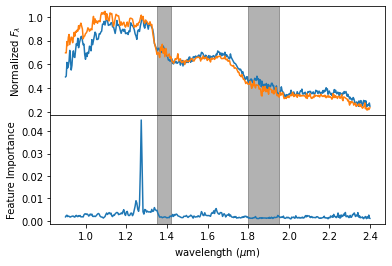

In [28]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_mid_G3, z_mid_G3)))
class_report_mid_G3 = classification_report(y_mid_G3,z_mid_G3, digits=4, output_dict=True)
print(class_report_mid_G3)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_mid))
Bin_i = random.randint(0,len(BinDF_mid))
ax[0].plot(list(wave),list(SinDF_mid.system_interpolated_flux.iloc[Sin_i]),label='single')
ax[0].plot(list(wave),list(BinDF_mid.system_interpolated_flux.iloc[Bin_i]),label='binary')
ax[0].set_ylabel('Normalized $F_\\lambda$')
ax[1].plot(list(wave), list(RF_mid_G3.feature_importances_)[:409])
ax[1].set_ylabel('Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

The raw features produce a model with precision ~0.9764
{'0': {'precision': 0.9357754769538025, 'recall': 0.9798040942108739, 'f1-score': 0.9572837979515578, 'support': 18172}, '1': {'precision': 0.9764002314963668, 'recall': 0.9255150554675119, 'f1-score': 0.9502769346309103, 'support': 16406}, 'accuracy': 0.9540459251547226, 'macro avg': {'precision': 0.9560878542250846, 'recall': 0.9526595748391928, 'f1-score': 0.9537803662912341, 'support': 34578}, 'weighted avg': {'precision': 0.955050441469544, 'recall': 0.9540459251547226, 'f1-score': 0.9539592968341264, 'support': 34578}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

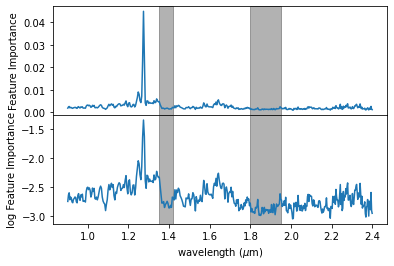

In [29]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_mid_G3, z_mid_G3)))
class_report_mid_G3 = classification_report(y_mid_G3,z_mid_G3, digits=4, output_dict=True)
print(class_report_mid_G3)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_mid))
Bin_i = random.randint(0,len(BinDF_mid))
ax[0].plot(list(wave), list(RF_mid_G3.feature_importances_)[:409])
ax[0].set_ylabel('Feature Importance')
ax[1].plot(list(wave), np.log10(list(RF_mid_G3.feature_importances_)[:409]))
ax[1].set_ylabel('log Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

In [30]:
start = time.time()
grid_mid_G4, data_mid_G4 = RF_optimize(DF_mid, wave, Group='G4')
RF_mid_G4 = grid_mid_G4.best_estimator_
X_mid_G4 = data_mid_G4['X_test']
y_mid_G4 = data_mid_G4['y_test']
z_mid_G4 = RF_mid_G4.predict(X_mid_G4)
end = time.time()
print(end-start)

563.3643958568573


In [31]:
grid_mid_G4.cv_results_

{'mean_fit_time': array([ 49.45282683,  40.44758048,  88.00877223, 129.62387743,
         86.04959254, 163.39771461, 182.58458905, 148.97480698,
        138.58340411,  63.30202918,  52.98026819,  38.42056375]),
 'std_fit_time': array([0.70875284, 0.63662566, 0.95409792, 2.1528878 , 1.43874146,
        2.32792886, 2.75286385, 1.0667578 , 6.21878159, 1.96607907,
        1.09093163, 3.76381614]),
 'mean_score_time': array([0.54956007, 0.51778388, 0.68016343, 0.82504473, 0.67677679,
        0.93508706, 0.99934945, 0.92491207, 0.62919869, 0.56778584,
        0.35907807, 0.38133721]),
 'std_score_time': array([0.00925188, 0.00616029, 0.01436683, 0.01787305, 0.02578469,
        0.01028528, 0.01663285, 0.04591697, 0.23302823, 0.07365284,
        0.0317217 , 0.08707001]),
 'param_n_estimators': masked_array(data=[39, 31, 85, 101, 69, 127, 147, 145, 117, 51, 53, 33],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
     

In [32]:
f1score_jd(y_mid_G4,z_mid_G4)

0.9401086919557473

The raw features produce a model with precision ~0.9765
{'0': {'precision': 0.9215422852152885, 'recall': 0.9864106988783434, 'f1-score': 0.9528737628060427, 'support': 13908}, '1': {'precision': 0.9764808362369338, 'recall': 0.8704381586245147, 'f1-score': 0.9204152249134948, 'support': 9015}, 'accuracy': 0.9408018147711905, 'macro avg': {'precision': 0.9490115607261111, 'recall': 0.928424428751429, 'f1-score': 0.9366444938597688, 'support': 22923}, 'weighted avg': {'precision': 0.9431481412315226, 'recall': 0.9408018147711905, 'f1-score': 0.9401086919557474, 'support': 22923}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

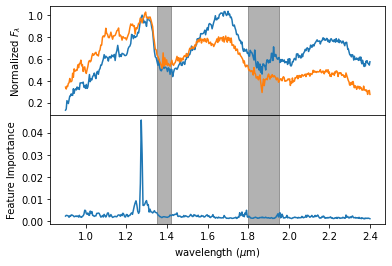

In [33]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_mid_G4, z_mid_G4)))
class_report_mid_G4 = classification_report(y_mid_G4,z_mid_G4, digits=4, output_dict=True)
print(class_report_mid_G4)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_mid))
Bin_i = random.randint(0,len(BinDF_mid))
ax[0].plot(list(wave),list(SinDF_mid.system_interpolated_flux.iloc[Sin_i]),label='single')
ax[0].plot(list(wave),list(BinDF_mid.system_interpolated_flux.iloc[Bin_i]),label='binary')
ax[0].set_ylabel('Normalized $F_\\lambda$')
ax[1].plot(list(wave), list(RF_mid_G4.feature_importances_)[:409])
ax[1].set_ylabel('Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

The raw features produce a model with precision ~0.9765
{'0': {'precision': 0.9215422852152885, 'recall': 0.9864106988783434, 'f1-score': 0.9528737628060427, 'support': 13908}, '1': {'precision': 0.9764808362369338, 'recall': 0.8704381586245147, 'f1-score': 0.9204152249134948, 'support': 9015}, 'accuracy': 0.9408018147711905, 'macro avg': {'precision': 0.9490115607261111, 'recall': 0.928424428751429, 'f1-score': 0.9366444938597688, 'support': 22923}, 'weighted avg': {'precision': 0.9431481412315226, 'recall': 0.9408018147711905, 'f1-score': 0.9401086919557474, 'support': 22923}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

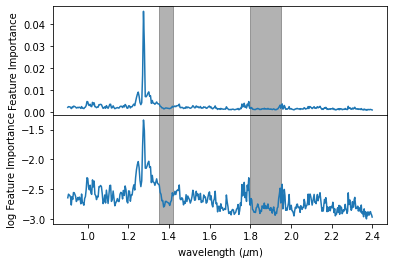

In [34]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_mid_G4, z_mid_G4)))
class_report_mid_G4 = classification_report(y_mid_G4,z_mid_G4, digits=4, output_dict=True)
print(class_report_mid_G4)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_mid))
Bin_i = random.randint(0,len(BinDF_mid))
ax[0].plot(list(wave), list(RF_mid_G4.feature_importances_)[:409])
ax[0].set_ylabel('Feature Importance')
ax[1].plot(list(wave), np.log10(list(RF_mid_G4.feature_importances_)[:409]))
ax[1].set_ylabel('log Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')